In [8]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import (
    BertTokenizer, 
    BertModel, 
    AutoTokenizer, 
    AutoModel, 
    AutoConfig, 
    Trainer, 
    TrainingArguments
)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch.nn as nn

In [9]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

label2id = {"contradiction": 0, "entailment": 1, "neutral": 2}

class CustomDebertaClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.1):
        super(CustomDebertaClassifier, self).__init__()
        # 載入預訓練配置與模型
        self.config = AutoConfig.from_pretrained(model_name)
        self.deberta = AutoModel.from_pretrained(model_name, config=self.config)
        # Freeze the DeBERTa base model (transfer learning: only fine-tune FC)
        for param in self.deberta.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # 取 [CLS] token 的 representation (pooler_output)
        pooled_output = outputs[0][:, 0]
        pooled_output = self.dropout(pooled_output)
        hidden = self.fc1(pooled_output)
        hidden = self.relu(hidden)
        logits = self.fc2(hidden)

        output = {"logits": logits}
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            output["loss"] = loss
        return output

In [10]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("SICK.txt", sep="\t")
# 保留所需欄位
df = df[["sentence_A", "sentence_B", "entailment_label"]]
print("原始資料形狀:", df.shape)
# 將標籤轉小寫，再映射成數值
df["entailment_label"] = df["entailment_label"].str.lower()
df["entailment_label"] = df["entailment_label"].map(label2id)

# 使用 stratified split 分 80%/20%
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["entailment_label"], random_state=42
)
print("訓練集形狀:", train_df.shape, "測試集形狀:", test_df.shape)

原始資料形狀: (9840, 3)
訓練集形狀: (7872, 3) 測試集形狀: (1968, 3)


In [11]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence_A"],
        examples["sentence_B"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

model_name = "tasksource/deberta-small-long-nli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

def rename_label(example):
    example["labels"] = example["entailment_label"]
    return example

train_dataset = train_dataset.map(rename_label)
test_dataset = test_dataset.map(rename_label)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 1968/1968 [00:00<00:00, 10374.22 examples/s]



使用訓練資料比例 1.0 (共 7872 筆資料)


/tmp/ipykernel_13250/872332995.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255100,0.267896,0.902439
2,0.265100,0.265226,0.906504
3,0.232400,0.265419,0.907012


比例 1.0 的 Evaluation results: {'eval_loss': 0.26522621512413025, 'eval_accuracy': 0.9065040650406504, 'eval_runtime': 9.8238, 'eval_samples_per_second': 200.33, 'eval_steps_per_second': 6.311, 'epoch': 3.0}
分類報告 (Train Subset 100%):
               precision    recall  f1-score   support

contradiction       0.88      0.91      0.89       285
   entailment       0.88      0.90      0.89       564
      neutral       0.93      0.91      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 100%):
[[ 258    1   26]
 [   1  507   56]
 [  33   67 1019]]


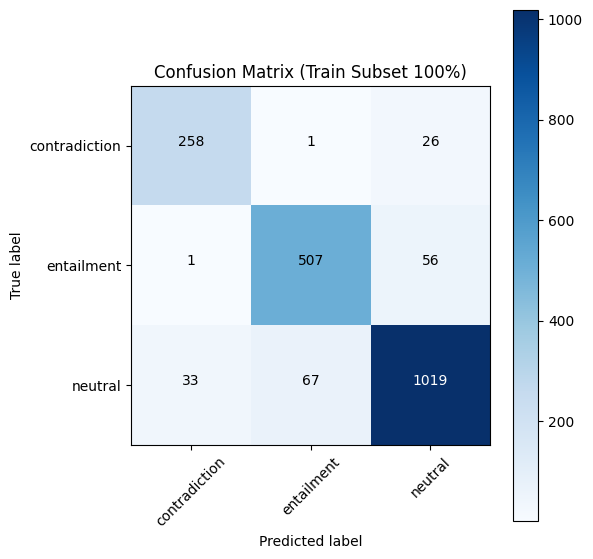


使用訓練資料比例 0.5 (共 3936 筆資料)


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_13250/872332995.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.255100,0.262216,0.908028
2,0.272000,0.262115,0.907520
3,0.209300,0.263086,0.907520


比例 0.5 的 Evaluation results: {'eval_loss': 0.262114554643631, 'eval_accuracy': 0.907520325203252, 'eval_runtime': 9.7493, 'eval_samples_per_second': 201.86, 'eval_steps_per_second': 6.359, 'epoch': 3.0}
分類報告 (Train Subset 50%):
               precision    recall  f1-score   support

contradiction       0.88      0.90      0.89       285
   entailment       0.89      0.90      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 50%):
[[ 257    1   27]
 [   1  505   58]
 [  34   61 1024]]


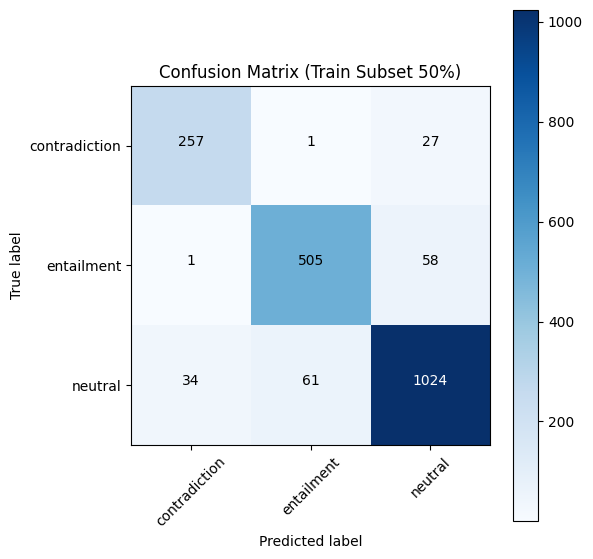


使用訓練資料比例 0.25 (共 1968 筆資料)


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_13250/872332995.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.350000,0.307191,0.907520
2,0.284500,0.267936,0.906504
3,0.281300,0.264652,0.907520


比例 0.25 的 Evaluation results: {'eval_loss': 0.2646518349647522, 'eval_accuracy': 0.907520325203252, 'eval_runtime': 9.7288, 'eval_samples_per_second': 202.286, 'eval_steps_per_second': 6.373, 'epoch': 3.0}
分類報告 (Train Subset 25%):
               precision    recall  f1-score   support

contradiction       0.89      0.89      0.89       285
   entailment       0.89      0.89      0.89       564
      neutral       0.92      0.92      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.90      0.90      0.90      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 25%):
[[ 255    1   29]
 [   1  504   59]
 [  30   62 1027]]


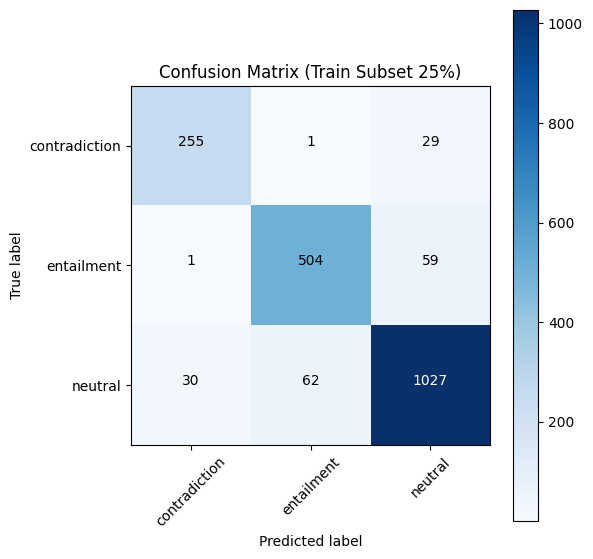


使用訓練資料比例 0.1 (共 787 筆資料)


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_13250/872332995.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.641500,0.544925,0.903963
2,0.453900,0.402175,0.909045
3,0.411200,0.373151,0.911077


比例 0.1 的 Evaluation results: {'eval_loss': 0.3731512725353241, 'eval_accuracy': 0.9110772357723578, 'eval_runtime': 9.7797, 'eval_samples_per_second': 201.233, 'eval_steps_per_second': 6.34, 'epoch': 3.0}
分類報告 (Train Subset 10%):
               precision    recall  f1-score   support

contradiction       0.94      0.87      0.90       285
   entailment       0.89      0.90      0.89       564
      neutral       0.92      0.93      0.92      1119

     accuracy                           0.91      1968
    macro avg       0.91      0.90      0.91      1968
 weighted avg       0.91      0.91      0.91      1968

Confusion Matrix (Train Subset 10%):
[[ 248    1   36]
 [   1  505   58]
 [  15   64 1040]]


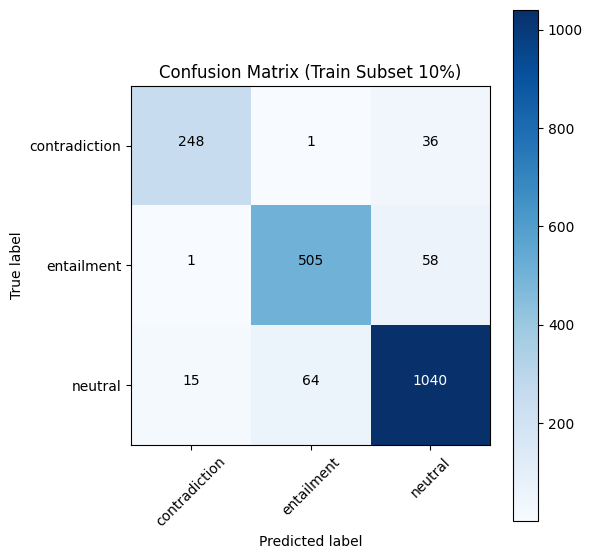

In [14]:
fractions = [1.0, 0.5, 0.25, 0.1]
num_labels = len(label2id)
results = {}

for frac in fractions:
    num_train_samples = int(len(train_dataset) * frac)
    train_subset = train_dataset.select(range(num_train_samples))
    print(f"\n使用訓練資料比例 {frac} (共 {num_train_samples} 筆資料)")
    
    model = CustomDebertaClassifier(model_name=model_name, num_labels=num_labels, dropout_rate=0.1)
    model.to(device)
    
    training_args = TrainingArguments(
        output_dir=f"./results_{int(frac*100)}",
        evaluation_strategy="epoch", 
        learning_rate=2e-5,
        save_strategy="epoch", 
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=10,
        load_best_model_at_end=True,
        logging_dir=f"./logs_{int(frac*100)}",
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    
    eval_results = trainer.evaluate()
    print(f"比例 {frac} 的 Evaluation results:", eval_results)
    
    predictions_output = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions_output.predictions, axis=-1)
    # 輸出分類報告
    print(f"分類報告 (Train Subset {int(frac*100)}%):")
    # 這裡 target_names 根據 label2id 的順序
    target_names = [k for k, v in sorted(label2id.items(), key=lambda item: item[1])]
    print(classification_report(test_dataset["labels"].numpy(), predicted_labels, target_names=target_names))
    
    results[frac] = eval_results
    
    # Compute the confusion matrix
    cm = confusion_matrix(test_dataset['labels'], predicted_labels)
    print(f"Confusion Matrix (Train Subset {int(frac*100)}%):")
    print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix (Train Subset {int(frac*100)}%)")
    plt.colorbar()

    # Define tick marks using the class names
    classes = target_names
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add numbers inside each cell
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
